<a href="https://colab.research.google.com/github/aSafarpoor/AI_Project_BypedalWalker/blob/master/SynthesizedDataSet/Simple_RW_MSG_Propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import os
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
random.seed(1)


#read phase

In [8]:
!wget https://github.com/aSafarpoor/storehouse/raw/main/1000-5.zip

--2024-04-29 05:22:53--  https://github.com/aSafarpoor/storehouse/raw/main/1000-5.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aSafarpoor/storehouse/main/1000-5.zip [following]
--2024-04-29 05:22:53--  https://raw.githubusercontent.com/aSafarpoor/storehouse/main/1000-5.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262830 (257K) [application/zip]
Saving to: ‘1000-5.zip’

1000-5.zip          100%[===================>] 256.67K  --.-KB/s    in 0.02s   

2024-04-29 05:22:53 (13.3 MB/s) - ‘1000-5.zip’ saved [262830/262830]



In [11]:
!unzip 1000-5.zip

Archive:  1000-5.zip
replace BA-1000-5-benignNodes.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: BA-1000-5-benignNodes.txt  
 extracting: random-1000-5-benignNodes.txt  
 extracting: BFS-1000-5-benignNodes.txt  
 extracting: BA-1000-5-sybilNodes.txt  
 extracting: random-1000-5-sybilNodes.txt  
 extracting: BFS-1000-5-sybilNodes.txt  
 extracting: BA-1000-5-allEdges.txt  
 extracting: random-1000-5-allEdges.txt  
 extracting: BFS-1000-5-allEdges.txt  


In [36]:
def readNodeFile(filename):
    with open(filename, 'r') as file:
        # Convert each line from string to float, then to integer
        nodes = [int(float(line.strip())) for line in file]
    return nodes

def readEdgeFile(filename):
    with open(filename, 'r') as file:
        # Convert each part of the line from string to float, then to integer
        edges = [tuple(int(float(part)) for part in line.strip().split(', ')) for line in file]
    return edges

def readAllFiles(directory):
    data = {}

    # List all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            full_path = os.path.join(directory, filename)

            # Check the type of data and read accordingly
            if 'benignNodes' in filename or 'sybilNodes' in filename:
                data[filename] = readNodeFile(full_path)
            elif 'allEdges' in filename:
                data[filename] = readEdgeFile(full_path)

    return data


In [37]:
allFileData = readAllFiles('.')

# Print the data to check it
for file_name, contents in allFileData.items():
    print(f"Contents of {file_name}:")


Contents of random-1000-5-benignNodes.txt:
Contents of random-1000-5-sybilNodes.txt:
Contents of BFS-1000-5-allEdges.txt:
Contents of BA-1000-5-allEdges.txt:
Contents of BFS-1000-5-benignNodes.txt:
Contents of BFS-1000-5-sybilNodes.txt:
Contents of BA-1000-5-sybilNodes.txt:
Contents of random-1000-5-allEdges.txt:
Contents of BA-1000-5-benignNodes.txt:


# RW

based on https://github.com/aSafarpoor/WhatIDoTheseDays/blob/main/oldercodes/Datasets%20propagation%20-%203%20important%20dataset%20and%20run%20sample.ipynb

In [32]:
class MSG_Propagation:
    def __init__(self,nodes,edges,initbenigns,initsybils,percentageoftrain=0.1,
                 is_directed = False, to_right=True,
                 is_A2 = False,
                 is_Weighted_Jaccard_Index_by_A = False,
                 is_Weighted_just_Jaccard=False):
        self.nodes = nodes
        self.edges = edges
        self.pmatrix = np.zeros(len(self.nodes))
        self.pmatrix = self.pmatrix.reshape((-1,1))

        self.A = np.zeros((len(nodes),len(nodes)))
        if not is_directed:
            for e in edges:
                self.A[e[0],e[1]] = 1
                self.A[e[1],e[0]] = 1
        else:
            if to_right:
                for e in edges:
                    self.A[e[0],e[1]] = 1
            else:
                for e in edges:
                    self.A[e[1],e[0]] = 1
        if is_A2:
            self.A = np.dot(self.A,self.A)

        if is_Weighted_Jaccard_Index_by_A:
            self.compute_Jaccard_of_matrix_based_on_A()
            self.A = self.A * self.Jaccard

        elif is_Weighted_just_Jaccard:
            self.compute_Jaccard_of_matrix_as_A()

        #normalization phase
        row_sums = self.A.sum(axis=0)  # Calculate the sum of each row

        for i in range(len(self.A)):
            if row_sums[i] > 0:
                self.A[i,:] /= row_sums[i]

        random.shuffle(initbenigns)
        random.shuffle(initsybils)

        self.btrain = initbenigns[:int(len(initbenigns)*percentageoftrain)]
        self.btest = initbenigns[int(len(initbenigns)*percentageoftrain):]
        self.strain = initsybils[:int(len(initsybils)*percentageoftrain)]
        self.stest = initsybils[int(len(initsybils)*percentageoftrain):]
        print("#train= b , s = ",len(self.btrain),' , ',len(self.strain))

    def compute_Jaccard_of_matrix_based_on_A(self):
        A = np.zeros((len(self.nodes), len(self.nodes)))

        # Calculate the dot product of the adjacency matrix with its transpose
        dot_product = np.dot(self.A, self.A.T)

        # Calculate the sum of each row of the adjacency matrix
        row_sums = self.A.sum(axis=1)

        for i in tqdm(range(len(A))):
            for j in range(i, len(A)):
                if self.A[i][j] > 0:
                    # Calculate the Jaccard index
                    intersection = dot_product[i, j]
                    union = row_sums[i] + row_sums[j] - intersection

                    if union == 0:
                        A[i, j] = A[j, i] = 0
                    else:
                        A[i, j] = A[j, i] = intersection / union

        np.fill_diagonal(A, 1)  # Set diagonal elements to 1
        self.Jaccard = A

    def compute_Jaccard_of_matrix_as_A(self):
        A = np.zeros((len(self.nodes), len(self.nodes)))

        # Calculate the dot product of the adjacency matrix with its transpose
        dot_product = np.dot(self.A, self.A.T)

        # Calculate the sum of each row of the adjacency matrix
        row_sums = self.A.sum(axis=1)

        for i in tqdm(range(len(A))):
            for j in range(i, len(A)):

                # Calculate the Jaccard index
                intersection = dot_product[i, j]
                union = row_sums[i] + row_sums[j] - intersection

                if union == 0:
                    A[i, j] = A[j, i] = 0
                else:
                    A[i, j] = A[j, i] = intersection / union

        np.fill_diagonal(A, 1)  # Set diagonal elements to 1
        self.Jaccard = A
        self.A = A

    def msg_prop(self,sybilval,beningval,rounds=5,alpha = 1,unknownval=0):
        self.rounds = rounds
        self.alpha = alpha
        pmatrix = np.ones(len(self.nodes)) * unknownval
        pmatrix = pmatrix.reshape((-1,1))
        value_list = []
        value_list.append(pmatrix[:])
        for x in self.btrain:
            pmatrix[x] = beningval
        for x in self.strain:
            pmatrix[x] = sybilval
        for i in range(rounds):
            pnew = np.dot(self.A,pmatrix)
            pmatrix = (1-alpha)* pmatrix + alpha* np.copy(pnew)
            value_list.append(pmatrix[:])
        # return pmatrix
        return value_list

    def test(self,value_list,th):
        btest = self.btest
        stest = self.stest

        output = np.array(value_list)[-1].reshape(-1)

        tb = fb = ts = fs = 0
        for i in btest:
            x = output[i]
            if x > th:
                tb += 1
            else:
                fs += 1

        for i in stest:
            x = output[i]
            if x > th:
                fb += 1
            else:
                ts += 1

        acc = (tb+ts)/(len(btest)+len(stest))

        def changelen(string):
            spaces_to_add = 6 - len(string)
            return " " * spaces_to_add + string
        tb = changelen(str(tb))
        fb = changelen(str(fb))
        ts = changelen(str(ts))
        fs = changelen(str(fs))

        print("#rounds=",self.rounds)
        print("alpha=  ",self.alpha)
        print("acc: ", acc)
        print("")
        print("      |    t     |    f     |")
        print("------|----------|----------|")
        print("   b  |  {:>6}  |  {:>6}  |".format(tb, fb))
        print("------|----------|----------|")
        print("   s  |  {:>6}  |  {:>6}  |".format(ts, fs))
        print("------|----------|----------|")

        return acc

In [ ]:
titles = ["random","BA","BFS"]
accList = {}

for title in titles:
    benignNodes = allFileData[title+"-1000-5-benignNodes"+".txt"]
    sybilNodes = allFileData[title+"-1000-5-sybilNodes"+".txt"]
    nodes = list(set(benignNodes) | set(sybilNodes))
    edges = allFileData[title+"-1000-5-allEdges"+".txt"]
    accList[title] = []
    for roundnumber in tqdm(range(0,50,3)):
        smsgp = MSG_Propagation(nodes,
                                edges,percentageoftrain=0.5,
                                initbenigns=benignNodes,
                                initsybils=sybilNodes,
                                is_directed = True,
                                to_right=True,
                                is_A2 = False,
                                is_Weighted_Jaccard_Index_by_A = False,
                                is_Weighted_just_Jaccard=False)
        values = smsgp.msg_prop(rounds=roundnumber,alpha = 0.5,sybilval=-1,beningval=1,unknownval=0)
        accList[title].append(smsgp.test(value_list=values,th=0))
    print(title," : ",accList[title])

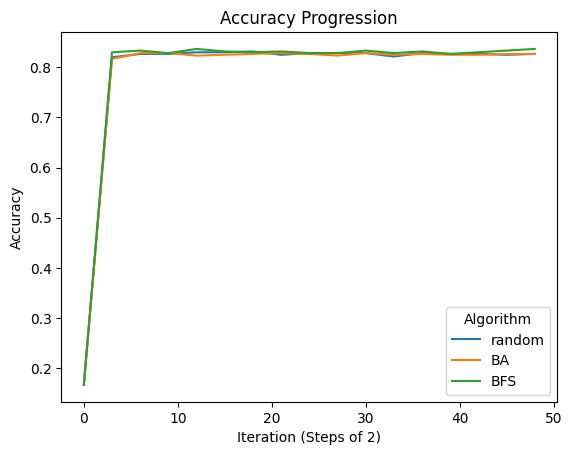

In [53]:
x_values = list(range(0, 50, 3))

for label, values in accList.items():
    plt.plot(x_values, values, label=label)

# Adding title and labels
plt.title('Accuracy Progression')
plt.xlabel('Iteration (Steps of 2)')
plt.ylabel('Accuracy')
plt.legend(title='Algorithm')

# Show the plot
plt.show()

In [54]:
for label, values in accList.items():
    print(label,': ', max(values))

random :  0.8316666666666667
BA :  0.8283333333333334
BFS :  0.8366666666666667


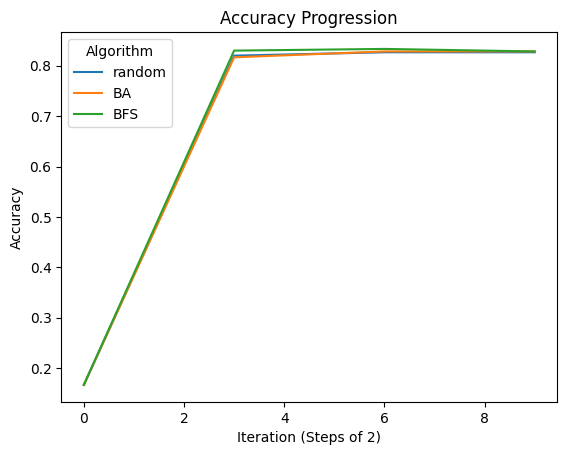

In [55]:
x_values = list(range(0, 10, 3))

for label, values in accList.items():
    plt.plot(x_values, values[:len(x_values)], label=label)

# Adding title and labels
plt.title('Accuracy Progression')
plt.xlabel('Iteration (Steps of 2)')
plt.ylabel('Accuracy')
plt.legend(title='Algorithm')

# Show the plot
plt.show()